In [ ]:
WANDB_PROJECT = "analysis3"
ENTITY = 'course'
CLASSES = {i:c for i,c in enumerate(['displaced', 'enucleated', 'irregular', 'micronucleus', 'normal', 'other'])}
RAW_DATA_ARTIFACT = 'dataset_23062023'
PROCESSED_DATA_ARTIFACT = 'dataset_23062023_split'

# Configurations

In [ ]:
# Installs
!pip3 install git+https://github.com/fastai/fastai.git timm wandb

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-1xmgagr4
  Running command git clone --filter=blob:none --quiet https://github.com/fastai/fastai.git /tmp/pip-req-build-1xmgagr4
  Resolved https://github.com/fastai/fastai.git to commit c7bf24745c8fab0ec5d8728924a65f25d4cabdd6
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
  Created wheel for fastai: filename=fastai-2.7.13-py3-none-an

In [ ]:
# Imports
import timm
import os
import wandb
import pandas as pd
import torchvision.models as tvmodels
from pathlib import Path
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
import albumentations
from sklearn.metrics import ConfusionMatrixDisplay
from IPython.display import display, Markdown

# Model setup

In [ ]:
# Model hyperparameters
train_config = SimpleNamespace(
    RUN_NAME='v2_resnet50_30e_bs16',
    IMG_SIZE=150,
    RESIZE_METHOD='squish',
    ARCH='resnet50',
    BS=16,
    EPOCHS=30,
    LR=3e-3,
    WD=0.15,
    SEED=18,
    LOG_PREDS=True,
)

In [ ]:
# Set seed and init run
set_seed(train_config.SEED, reproducible=True)
run = wandb.init(project=WANDB_PROJECT, entity=ENTITY, job_type="training", config=train_config, name=train_config.RUN_NAME)
config = wandb.config

In [ ]:
def label_func(fname):
    if parent_label(fname) not in ['notched', 'segmented', 'tailed']:
        return parent_label(fname)
    else:
        return 'irregular'

# Get artifact
processed_data_artifact = run.use_artifact(f'{PROCESSED_DATA_ARTIFACT}:latest')
dataset_dir = Path(processed_data_artifact.download())

# Create df
df = pd.read_csv(dataset_dir / 'data_split.csv', keep_default_na=False)
df = df[df.split != 'test'].reset_index(drop=True)
df['is_valid'] = df.split == 'valid'
df["file_path"] = [dataset_dir/f'images/{f}' for f in df.file_name.values]
df["label"] = [label_func(f) for f in df.file_name.values]

wandb:   2133 of 2133 files downloaded.  


In [ ]:
# Class that allows the use of Albumentations
class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()

    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

# Select the transformations
def get_augs_albumentations(size):
    return albumentations.Compose([
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.Rotate(p=0.5),
        albumentations.Sharpen(p=0.5),
        albumentations.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.5, hue=0.0, p=0.5),
        albumentations.RGBShift(p=0.5),
        albumentations.GaussianBlur(p=0.5),
        albumentations.GaussNoise(p=0.5),
        albumentations.RandomSizedCrop((120,140), size, size, p=0.5)
        ])

In [ ]:
# Create datablock
cells = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('file_path'),
    get_y=ColReader('label'),
    splitter=ColSplitter(col='is_valid'),
    item_tfms=[Resize(config.IMG_SIZE, method=config.RESIZE_METHOD), AlbumentationsTransform(get_augs_albumentations(config.IMG_SIZE))])

# Create dataloaders
dls = cells.dataloaders(df, bs=config.BS, shuffle=True)

# Explore classes
num_classes = dls.c
classes = dls.vocab
print('Cantidad de clases: ', num_classes)
print('Nombres de las clases: ', classes)

Cantidad de clases:  6
Nombres de las clases:  ['displaced', 'enucleated', 'irregular', 'micronucleus', 'normal', 'other']


In [ ]:
import torchvision.models as tvmodels

# Select metrics
metrics = [accuracy, F1Score(average='macro')]

# Create model
learn = vision_learner(dls,
                    getattr(tvmodels, config.ARCH),
                    normalize=True,
                    pretrained=True,
                    opt_func=Adam,
                    metrics=metrics,
                    wd=config.WD).to_fp16()

# Select callbacks
callbacks = [
    SaveModelCallback(monitor='f1_score'),
    WandbCallback(log_preds=config.LOG_PREDS, log_model=True)]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Visualize data

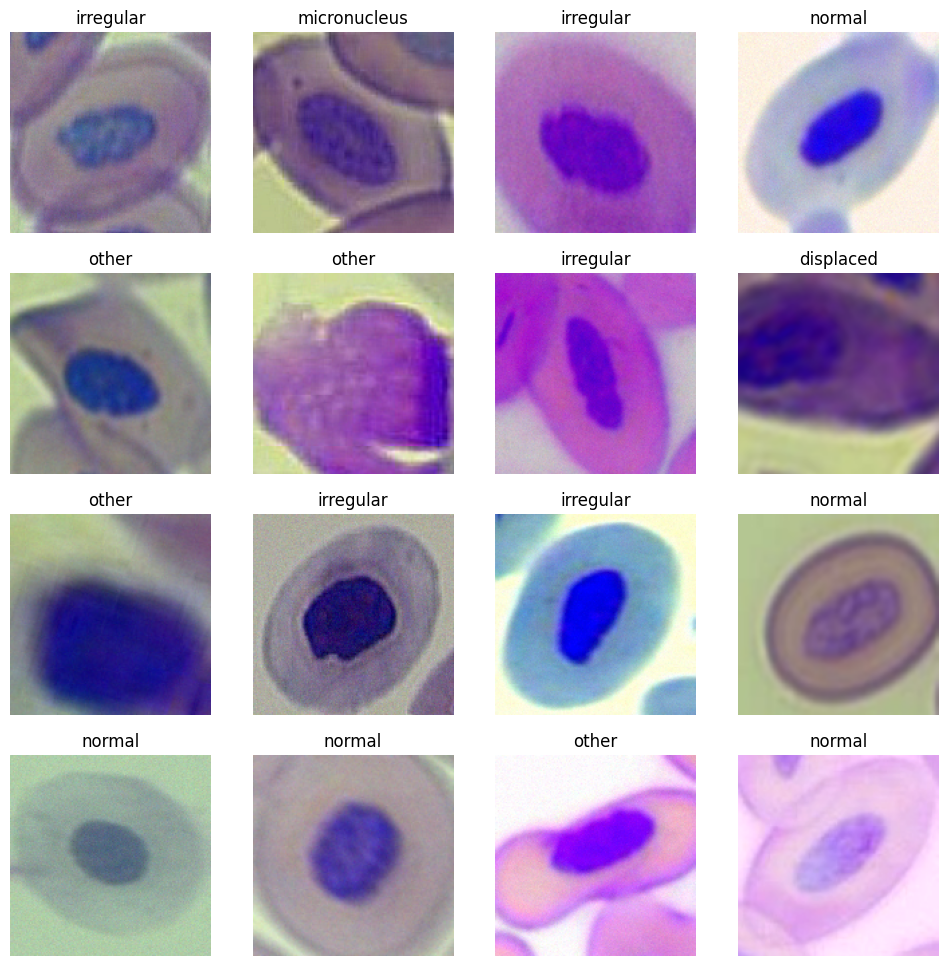

In [ ]:
# Show random images
dls.train.show_batch(max_n=16)

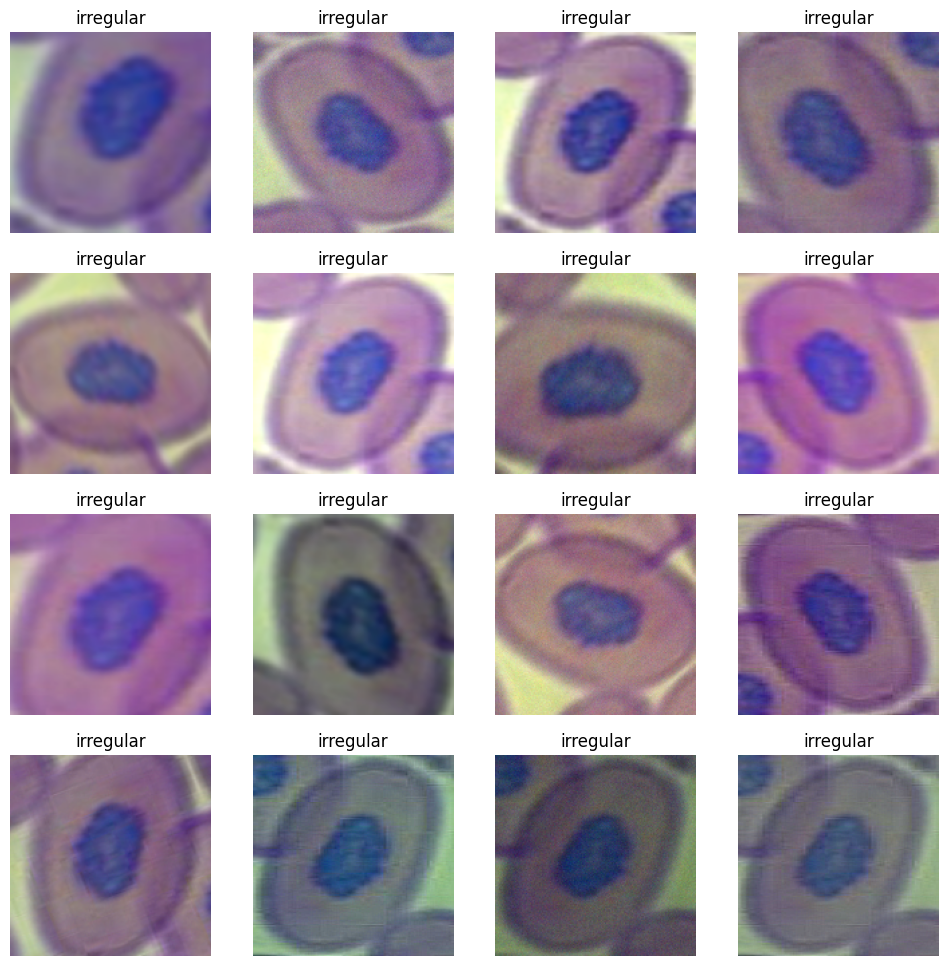

In [ ]:
# Show different versions of the same image
dls.train.show_batch(max_n=16, unique=True)

# Training

In [ ]:
# Train model
learn.fine_tune(config.EPOCHS, base_lr=config.LR, cbs=callbacks)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.318000,1.793773,0.607477,0.420266,00:09


Better model found at epoch 0 with f1_score value: 0.42026648874474964.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.866571,1.024978,0.677570,0.456331,00:12
1,1.441500,0.889219,0.682243,0.488645,00:08
2,1.235371,1.117849,0.700935,0.475526,00:09
3,1.178115,0.968388,0.700935,0.385925,00:10
4,1.053012,0.797437,0.757009,0.525740,00:08
5,1.025728,0.885679,0.705607,0.531278,00:10
6,0.971201,0.748511,0.733645,0.545035,00:12
7,0.916126,0.685491,0.775701,0.554871,00:12
8,0.774377,0.767156,0.705607,0.573526,00:08
9,0.778653,0.719331,0.733645,0.651413,00:10


wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.3 seconds.), retrying request


Better model found at epoch 0 with f1_score value: 0.45633053221288516.
Better model found at epoch 1 with f1_score value: 0.48864483419026206.


wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.3 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.2 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.2 seconds.), retrying request


Better model found at epoch 4 with f1_score value: 0.5257403632356897.
Better model found at epoch 5 with f1_score value: 0.5312779337779339.
Better model found at epoch 6 with f1_score value: 0.5450354046672675.
Better model found at epoch 7 with f1_score value: 0.5548709050229812.
Better model found at epoch 8 with f1_score value: 0.5735261554665853.
Better model found at epoch 9 with f1_score value: 0.6514130605607145.
Better model found at epoch 12 with f1_score value: 0.6608773909947313.
Better model found at epoch 13 with f1_score value: 0.7238668316088491.
Better model found at epoch 17 with f1_score value: 0.7647709765356825.
Better model found at epoch 22 with f1_score value: 0.7703271522618064.


# Evaluation

In [ ]:
# Prepare a row for the predictions table
def create_row(sample, class_pred, raw_pred, loss, dataset_row):
    (image, label) = sample
    image = image.permute(1, 2, 0)

    row =[dataset_row[0],                                       # image filename
          wandb.Image(image),                                   # image
          label,                                                # ground truth
          class_pred[0],                                        # prediction
          loss.item(),                                          # loss
          np.max(raw_pred.numpy())                              # confidence
    ]
    return row

# Create a table with images, labels, predictions and confidences
def create_predictions_table(samples, classes_preds, raw_preds, losses, dataset_df):
    items = list(zip(samples, classes_preds, raw_preds, losses, dataset_df.values))
    table = wandb.Table(
        columns=["file_name", "image", "ground_truth", "prediction", "loss", "confidence"]
    )
    # we create one row per sample
    for item in progress_bar(items):
        table.add_data(*create_row(*item))

    return table

# Obtain ground truths and predictions
def get_predictions(learner, test_dl=None, max_n=None):
    test_dl = learner.dls.valid if test_dl is None else test_dl
    dataset_df = test_dl.dataset.items
    inputs, raw_preds, ground_truths, decoded_preds, losses = learner.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True)
    _, _, samples, classes_preds = learner.dls.valid.show_results(tuplify(inputs) + tuplify(ground_truths), decoded_preds, show=False, max_n=max_n)
    return samples, classes_preds, raw_preds, losses, dataset_df

# Create a confusion matrix
def get_confusion_matrix(learner, ds_idx=1, return_vals=False, normalize=False):
    probs, targs = learner.get_preds(ds_idx=ds_idx)
    preds = probs.argmax(dim=1)
    classes = list(CLASSES.values())
    y_true = targs.flatten().numpy()
    y_pred = preds.flatten().numpy()

    tdf, pdf = [pd.DataFrame(r).value_counts().to_frame(c) for r,c in zip((y_true, y_pred) , ['y_true', 'y_pred'])]
    countdf = tdf.join(pdf, how='outer').reset_index(drop=True).fillna(0).astype(int).rename(index=CLASSES)
    countdf = countdf/countdf.sum()
    display(Markdown('### % Of Each Class'))
    display(countdf.style.format('{:.1%}'))

    plt.rcParams.update({'font.size': 18})
    normalize = 'true' if normalize == True else None
    disp = ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred,
                                                   display_labels=classes,
                                                   normalize=normalize,
                                                   cmap='YlGn')
    fig = disp.ax_.get_figure()
    fig.set_figwidth(15)
    fig.set_figheight(15)
    disp.ax_.set_title('Confusion Matrix', fontdict={'fontsize': 32, 'fontweight': 'medium'})
    fig.show()
    fig.autofmt_xdate(rotation=45)

    if return_vals: return countdf, disp

### % Of Each Class

,y_true,y_pred
displaced,5.6%,2.8%
enucleated,0.9%,0.9%
irregular,27.1%,21.5%
micronucleus,1.9%,0.5%
normal,37.4%,47.2%
other,27.1%,27.1%


### % Of Each Class

,y_true,y_pred
displaced,5.6%,2.8%
enucleated,0.9%,0.9%
irregular,27.1%,21.5%
micronucleus,1.9%,0.5%
normal,37.4%,47.2%
other,27.1%,27.1%


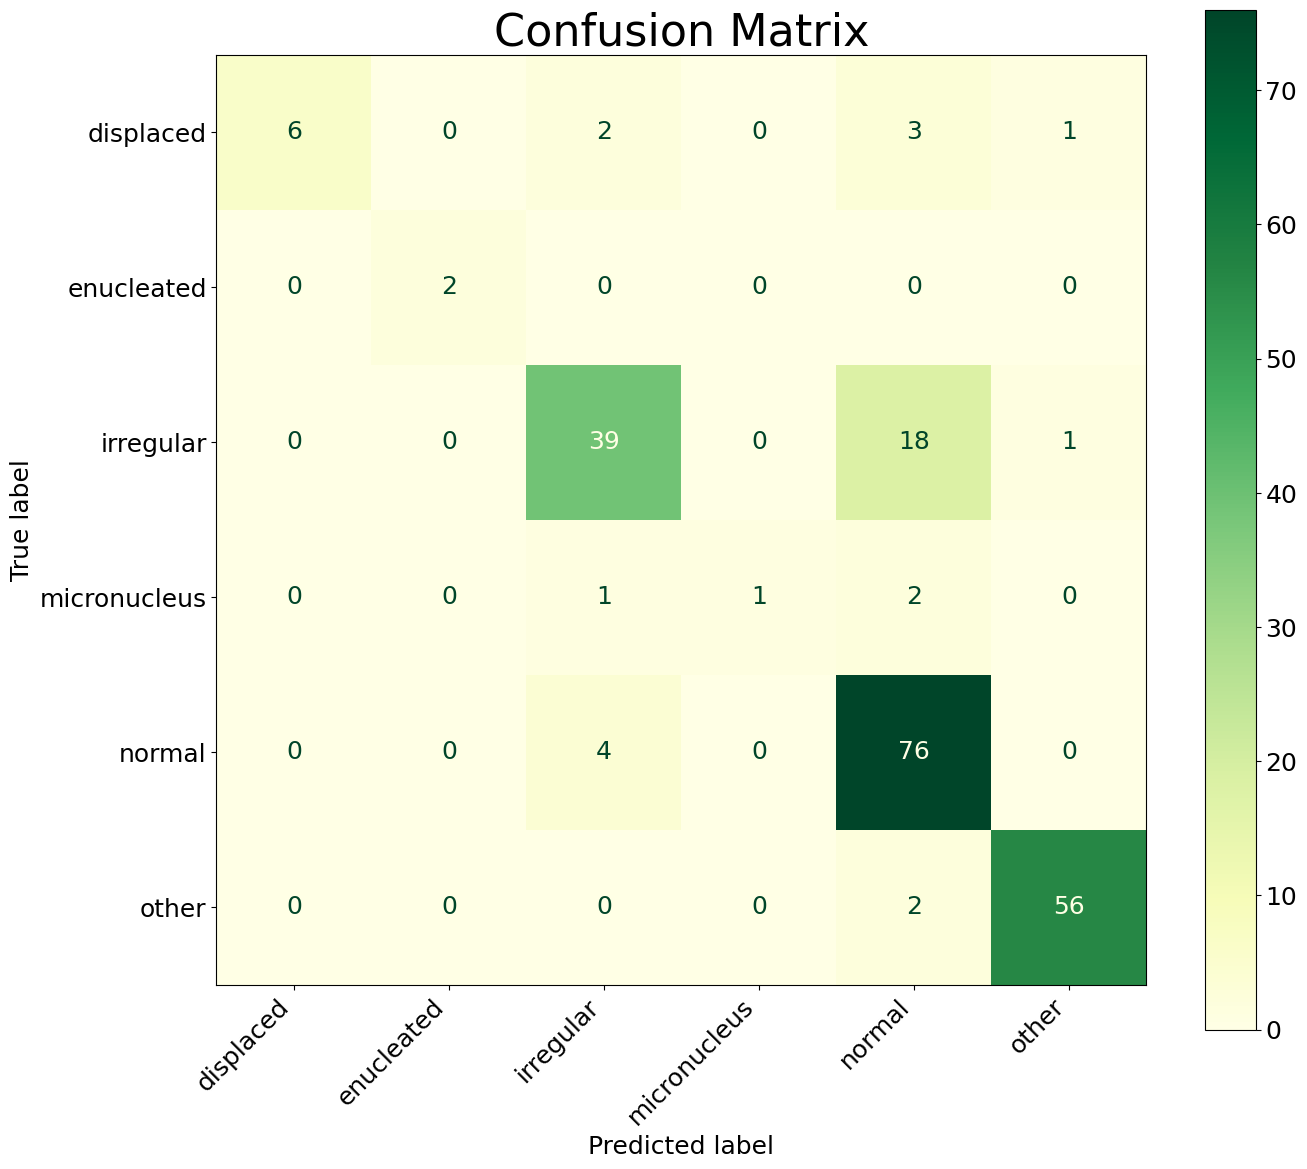

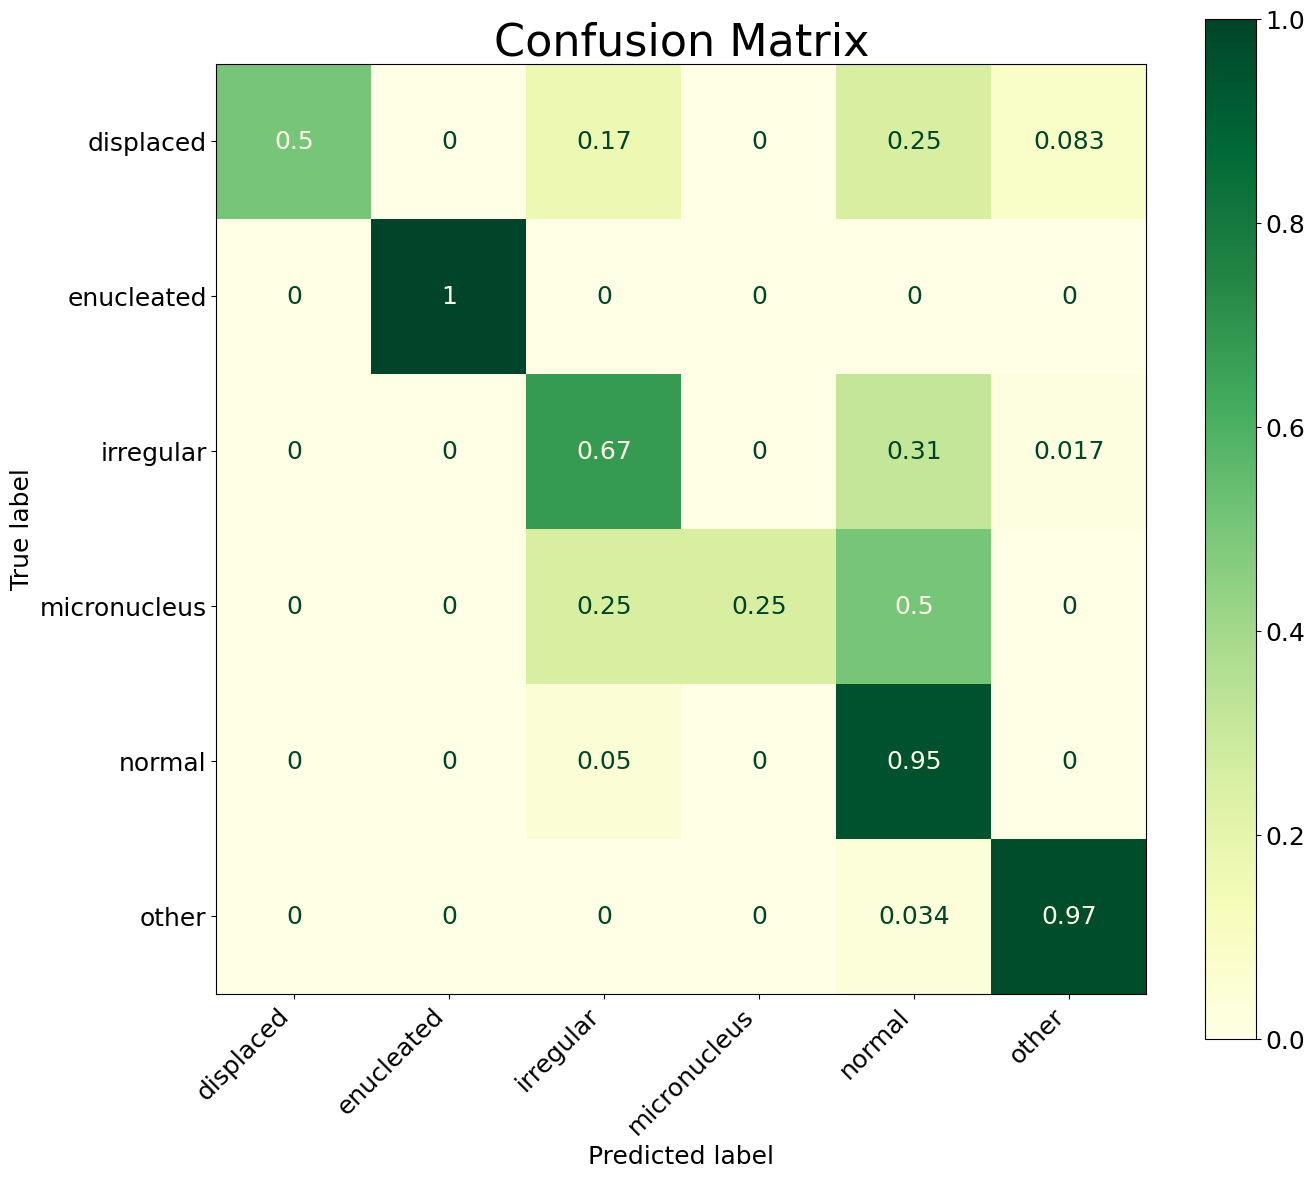

In [ ]:
# Create predictions table
samples, classes_preds, raw_preds, losses, dataset_df = get_predictions(learn, learn.dls.valid)
table = create_predictions_table(samples, classes_preds, raw_preds, losses, dataset_df)

# Create training table (delete augmentations first)
valid_ds = learn.dls.valid.dataset
learn.dls.valid.dataset = learn.dls.train.dataset
samples_train, classes_preds_train, raw_preds_train, losses_train, dataset_df_train = get_predictions(learn, learn.dls.train)
table_train = create_predictions_table(samples_train, classes_preds_train, raw_preds_train, losses_train, dataset_df_train)
learn.dls.valid.dataset = valid_ds

# Create confusion matrices
_, confusion_matrix = get_confusion_matrix(learner=learn, ds_idx=1, return_vals=True, normalize=False)
_, confusion_matrix_normalized = get_confusion_matrix(learner=learn, ds_idx=1, return_vals=True, normalize=True)

In [ ]:
# Log things
wandb.log({"valid_table":table})
wandb.log({"train_table":table_train})
wandb.log({'confusion_matrix': confusion_matrix.figure_})
wandb.log({'confusion_matrix_normalized': confusion_matrix_normalized.figure_})

In [ ]:
# Log final metrics
scores = learn.validate()
metric_names = ['final_loss'] + [f'final_{x.name}' for x in learn.metrics]
final_results = {metric_names[i] : scores[i] for i in range(len(scores))}
for k,v in final_results.items():
    wandb.summary[k] = v

In [ ]:
# Finish run
wandb.finish()